## Importing Necessary Libraries

In [473]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

## Static Information

In [474]:
confirmed_global = 'data/time_series_covid19_confirmed_global.csv'
deaths_global = 'data/time_series_covid19_deaths_global.csv'
recovered_global = 'data/time_series_covid19_recovered_global.csv'

## Helper functions needed

In [475]:
def import_data(path):
    df = pd.read_csv(path)
    return df 

In [476]:
def get_daily_counts(confirmed_df):
    confirmed_df_testing = confirmed_df.copy()
    static_cols = ['Province/State', 'Country/Region', 'Lat', 'Long']
    c_diff_df = pd.DataFrame()
    for i in range(0, len(confirmed_df_testing.columns)-1):
        if confirmed_df_testing.columns[i] not in static_cols:
            c_diff_df[confirmed_df_testing.columns[i]] = confirmed_df_testing[confirmed_df_testing.columns[i+1]].astype(int) - confirmed_df_testing[confirmed_df_testing.columns[i]].astype(int)
    return c_diff_df

In [477]:
def create_monthly_analysis_old(df, retain_extra_columns = False):
    years = ['20','21','22']
    months_mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    century = '20'
    months = [i for i in range(1,13)]
    static_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
    date_columns = [j for j in df.columns if j not in static_columns]
    df_months = df.copy()
    # df_months['tilldate'] = 0
    for year in years:
        for month in months:
            date_month = str(month)+'/'+str(year)
            str_date_month = months_mapping[month] + ' ' +str(century)+str(year)
            df_months[str_date_month] = 0
            for i in df_months.columns:
                datematch = rf"{month}/\d{{1,2}}/{year}"
                date = re.compile(datematch)
                matched = date.search(str(i))
                if matched != None:
                    df_months[str_date_month] = df_months[i].astype(int) + df_months[str_date_month]
            # df_months['tilldate'] = df_months[date_month] + df_months['tilldate']
    df_months = df_months.drop(columns = date_columns, axis = 1)
    df_countries = df_months['Country/Region']
    if retain_extra_columns == True:
        stale_columns = ['Apr 2022','May 2022','Jun 2022','Jul 2022','Aug 2022','Sep 2022','Oct 2022','Nov 2022','Dec 2022']
    else:
        stale_columns = ['Apr 2022','May 2022','Jun 2022','Jul 2022','Aug 2022','Sep 2022','Oct 2022','Nov 2022','Dec 2022', 'Province/State', 'Lat', 'Long']
    # stale_columns =  ['Province/State', 'Lat', 'Long']
    df_months = df_months.drop(columns = stale_columns, axis = 1)
    df_months = df_months.set_index('Country/Region')
    #Total sum per row: 
    df_months.loc['global',:]= df_months.sum(axis=0)
    #Total sum per row: 
    df_months.loc[:,'tilldate'] = df_months.sum(axis=1)
    # df_months['Country/Region'] = df_countries
    return df_months

In [538]:
def create_monthly_analysis(df, retain_extra_columns = False, end_month = None):
    years = ['20','21','22']
    months_mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    century = '20'
    months = [i for i in range(1,13)]
    this_year = datetime.today().strftime("%y")
    this_month = int(datetime.today().strftime("%m"))
    static_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
    date_columns = [j for j in df.columns if j not in static_columns]
    
    df_months = get_daily_counts(df)
    
    current_year = 0
    condition_stop = 0
    monthly_df = pd.DataFrame(df['Country/Region'], columns = ['Country/Region'])
    
    for year in years:
        if condition_stop == 1:
            break
        if year == this_year:
            current_year = 1
        for month in months:
            if current_year == 1 and month == this_month+1:
                condition_stop = 1
                break
            str_date_month = months_mapping[month] + ' ' +str(century)+str(year)
            if end_month == str_date_month:
                condition_stop = 1
                break
            monthly_df[str_date_month] = 0
            cum_count = 0
            for i in df_months.columns:
                datematch = rf"\b{month}\b/\d{{1,2}}/{year}"              
                date = re.compile(datematch)
                matched = date.search(str(i))
                if matched != None:
                    cum_count = df_months[i][0].astype(int) + cum_count
                    
                    monthly_df[str_date_month] = df_months[i].astype(int) + monthly_df[str_date_month]
            
    if retain_extra_columns == True:
        for col in static_columns:
            monthly_df[col] = df[col]
    
    monthly_df = monthly_df.set_index('Country/Region')
    monthly_df
    #Total sum per row: 
    monthly_df.loc['global',:]= monthly_df.sum(axis=0)
    
    #Total sum per column: 
    monthly_df.loc[:,'tilldate'] = monthly_df.sum(axis=1)

    return monthly_df

In [562]:
def plot_line_graph(x,y,title,xlabel,ylabel, color='blue', rotation=90, subplot_num=None, axis = None, fillcolor='skyblue',figsize=(10,5), scale = None):
    # importing libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    
    if axis == None:
        figure, axis = plt.subplots(1, 1, figsize=figsize)
    if subplot_num != None:
        axis = axis[subplot_num]
    axis.plot(x, y, color =color)
    axis.set_title(title)
    plt.setp(axis.get_xticklabels(), rotation=rotation)
    plt.fill_between(x, y, alpha=0.4, color=fillcolor)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    current_values = plt.gca().get_yticks()
    if scale == None:
        axis.set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
    elif scale == 'K':
        axis.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks()/1E3])
    elif scale == 'M':
        axis.set_yticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
    plt.show()
 

In [574]:
def addlabels(inp_x, inp_y, axis, scale = None, orient='h'):
    if orient == 'h':
        x = inp_y
        y = inp_x
        for i in range(len(y)):
            if x[i] <= 10 :            
                x_pos = x[i] + 100
            else:
                x_pos = x[i]
            if scale == None:
                x_values = [int(i) for i in x]
            elif scale == 'K':
                x_values = ['{:,.0f}'.format(i/1E3) + 'K' for i in x]
            elif scale == 'M':
                x_values = ['{:,.0f}'.format(i/1E6) + 'M' for i in x]
            axis.text(x_pos, i, x_values[i], ha = 'right')        
    else:
        x = inp_x
        y = inp_y
        for i in range(len(x)):
            if y[i] <= 10 :            
                y_pos = y[i] + 50
            else:
                y_pos = y[i]
            if scale == None:
                y_values = [int(i) for i in y]
            elif scale == 'K':
                y_values = ['{:,.0f}'.format(i/1E3) + 'K' for i in y]
            elif scale == 'M':
                y_values = ['{:,.0f}'.format(i/1E6) + 'M' for i in y]
            axis.text(i, y_pos, y_values[i], ha = 'center')

In [572]:
def plot_bar_graph(x, y, title, xlabel, ylabel, color='blue', rotation=0, width = 0.8, axis =None, subplot_num=None, figsize=(10,5), scale = None, add_labels = True, orient='h'):
    import matplotlib.pyplot as plt 
    if orient == 'h':          
        if axis == None:
            figure, axis = plt.subplots(1, 1, figsize=figsize)
        if subplot_num != None:
            axis = axis[subplot_num]
        axis.barh(y=x, width=y, color = color, height = width)
        axis.set_title(title)
        # plt.setp(axis.get_xticklabels(), rotation=rotation)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        current_values = plt.gca().get_xticks()
        if scale == None:
            axis.set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
        elif scale == 'K':
            axis.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_xticks()/1E3])
        elif scale == 'M':
            axis.set_xticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_xticks()/1E6])
        if add_labels:
            addlabels(x, y, axis, scale = scale, orient = orient)
        plt.show()
    else:
        if axis == None:
            figure, axis = plt.subplots(1, 1, figsize=figsize)
        if subplot_num != None:
            axis = axis[subplot_num]
        axis.bar(x, y, color = color, width = width)
        axis.set_title(title)
        plt.setp(axis.get_xticklabels(), rotation=rotation)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        current_values = plt.gca().get_yticks()
        if scale == None:
            axis.set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
        elif scale == 'K':
            axis.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks()/1E3])
        elif scale == 'M':
            axis.set_yticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
        if add_labels:
            addlabels(x, y, axis, scale = scale, orient = orient)
        plt.show()
    

## Loading Input Data

In [539]:
confirmed_df = import_data(confirmed_global)
deaths_df = import_data(deaths_global)
recovered_df = import_data(recovered_global)

## Creating monthly analysis for confirmed cases and deaths observed

In [540]:
confirmed_monthly = create_monthly_analysis(confirmed_df)
deaths_monthly = create_monthly_analysis(deaths_df)

In [541]:
recovered_monthly = create_monthly_analysis(recovered_df, end_month = 'Aug 2021')

### Creating global time series data 

In [542]:
global_table = pd.DataFrame(columns = confirmed_monthly.columns)
global_table = global_table.drop(columns = ['tilldate'], axis = 1)
global_table.loc['confirmed'] = confirmed_monthly.loc['global']
global_table.loc['deaths'] = deaths_monthly.loc['global']
global_table.loc['recoveries'] = recovered_monthly.loc['global']
global_table.head()

,Jan 2020,Feb 2020,Mar 2020,Apr 2020,May 2020,Jun 2020,Jul 2020,Aug 2020,Sep 2020,Oct 2020,...,Jun 2021,Jul 2021,Aug 2021,Sep 2021,Oct 2021,Nov 2021,Dec 2021,Jan 2022,Feb 2022,Mar 2022
confirmed,11481.0,76385.0,872362.0,2406205.0,2911691.0,4406248.0,7148975.0,7963810.0,8548838.0,12236231.0,...,11450145.0,15726041.0,20139779.0,15849929.0,13000382.0,16027953.0,26043708.0,92366062.0,56332629.0,18158151.0
deaths,242.0,2738.0,47905.0,196439.0,147726.0,146663.0,176632.0,183983.0,171064.0,180736.0,...,276324.0,268223.0,304922.0,260719.0,214197.0,219178.0,217096.0,247717.0,273133.0,75384.0
recoveries,257.0,42434.0,150354.0,858714.0,1640243.0,2776392.0,5085119.0,6527836.0,6820066.0,7201824.0,...,11264827.0,9985913.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### PLotting the global trends 

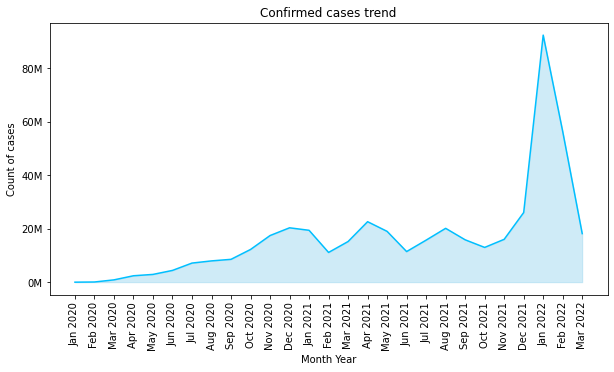

In [543]:
plot_line_graph(global_table.columns, global_table.loc['confirmed'].values.tolist(),'Confirmed cases trend', 'Month Year', 'Count of cases', color='deepskyblue', fillcolor='skyblue', scale = "M")

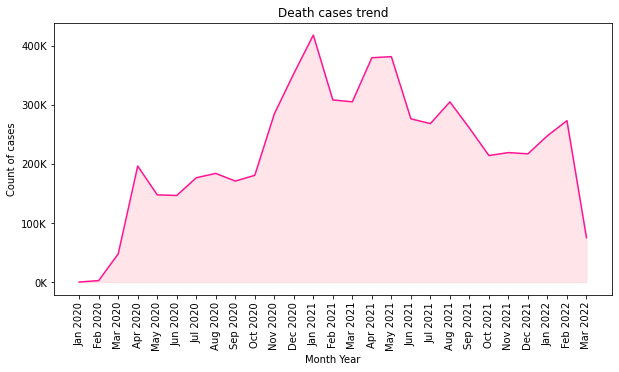

In [544]:
plot_line_graph(global_table.columns, global_table.loc['deaths'].values.tolist(),'Death cases trend', 'Month Year', 'Count of cases', color='deeppink', fillcolor='pink', scale = 'K')

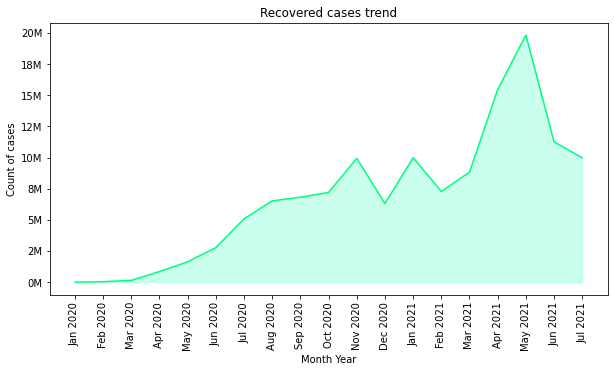

In [545]:
plot_line_graph(global_table.columns, global_table.loc['recoveries'].values.tolist(),'Recovered cases trend', 'Month Year', 'Count of cases', color='springgreen', fillcolor='aquamarine', scale = 'M')


### Obtaining country wise summary figures

In [553]:
country_wise_total_df = pd.DataFrame(columns=['confirmed','deaths'])
# country_wise_total_df['rec'] = recovered_monthly['tilldate']
country_wise_total_df['confirmed'] = confirmed_monthly['tilldate']
country_wise_total_df['deaths'] = deaths_monthly['tilldate']
country_wise_total_df = country_wise_total_df.join(pd.DataFrame(recovered_monthly['tilldate']))
country_wise_total_df = country_wise_total_df.rename(columns={"tilldate":"recoveries"})
country_wise_total_df = country_wise_total_df.drop('global')
country_wise_total_df = country_wise_total_df.drop('Winter Olympics 2022')
country_wise_total_df = country_wise_total_df.drop('Summer Olympics 2020')
country_wise_total_df.head()

,confirmed,deaths,recoveries
Country/Region,,,
Afghanistan,176039.0,7641.0,82586.0
Albania,272621.0,3485.0,130243.0
Algeria,265410.0,6862.0,116009.0
Andorra,38794.0,152.0,14210.0
Angola,98909.0,1900.0,37397.0


#### Plotting top 5 most affected countries

In [558]:
top_affected_countries = (country_wise_total_df.groupby('Country/Region')['confirmed'].sum()).sort_values(ascending = False).head(10)

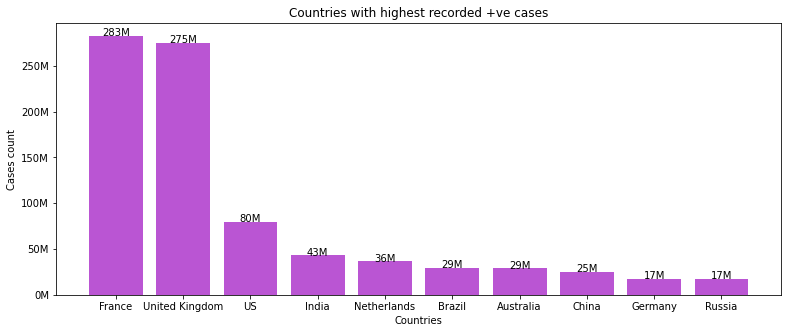

In [575]:
plot_bar_graph(top_affected_countries.index, top_affected_countries.values.tolist(), 'Countries with highest recorded +ve cases', 'Countries', 'Cases count', color='mediumorchid', rotation=0, width=0.8, scale = 'M',figsize=(13,5), orient = 'v')

#### Plotting top 5 least affected countries

In [576]:
least_affected_countries = (country_wise_total_df.groupby('Country/Region')['confirmed'].sum()).sort_values(ascending = True).head(10)

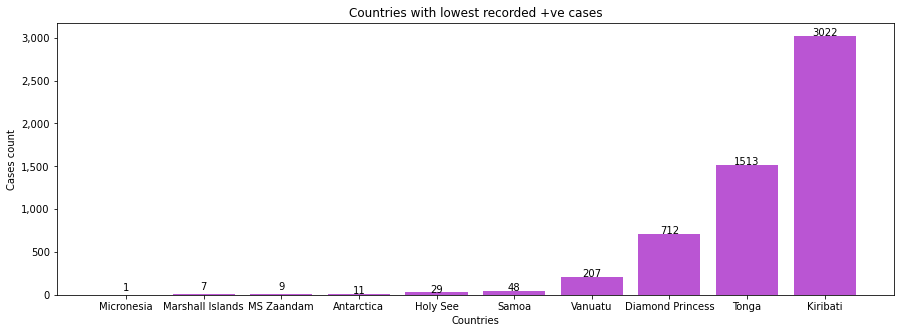

In [579]:
plot_bar_graph(least_affected_countries.index, least_affected_countries.values.tolist(), 'Countries with lowest recorded +ve cases', 'Countries', 'Cases count', color='mediumorchid', rotation=0, width=0.8, figsize=(15,5), orient = 'v')

#### Plotting top 5 countries with most casualities

In [178]:
top_deaths_countries = (country_wise_total_df.groupby('Country/Region')['deaths'].sum()).sort_values(ascending = False).head(10)

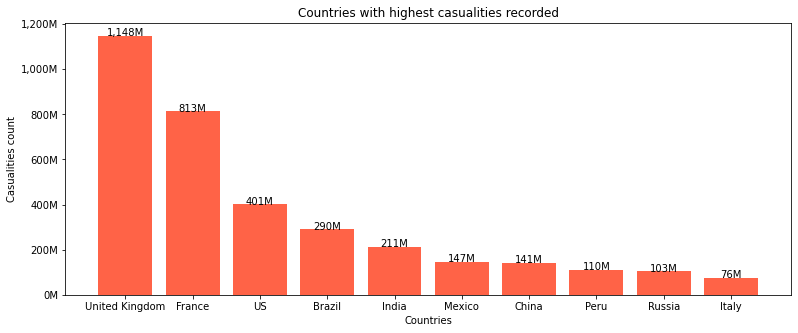

In [192]:
plot_bar_graph(top_deaths_countries.index, top_deaths_countries.values.tolist(), 'Countries with highest casualities recorded', 'Countries', 'Casualities count', color='tomato', rotation=0, width=0.8, figsize=(13,5))

#### Plotting top 5 least affected countries

In [173]:
least_deaths_countries = (country_wise_total_df.groupby('Country/Region')['deaths'].sum()).sort_values(ascending = True).head(10)

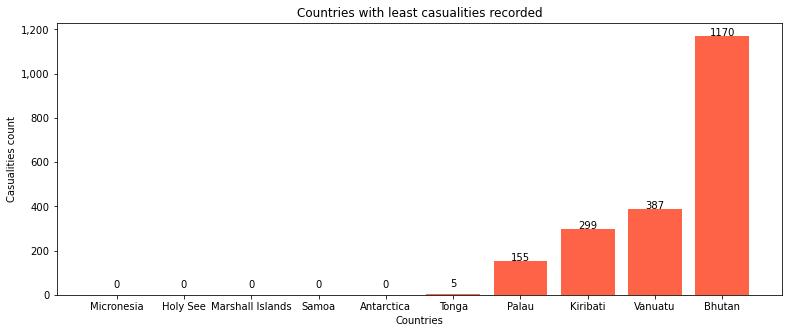

In [191]:
plot_bar_graph(least_deaths_countries.index, least_deaths_countries.values.tolist(), 'Countries with least casualities recorded', 'Countries', 'Casualities count', color='tomato', rotation=0, width=0.8, figsize=(13,5), million_scale=False)

#### Plotting top 10 fast recovering countries

In [266]:
top_recoveries_countries = (country_wise_total_df.groupby('Country/Region')['recoveries'].sum()).sort_values(ascending = False).head(10).sort_values(ascending = True)

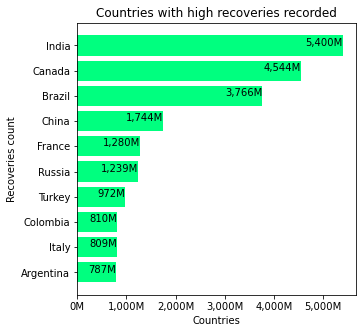

In [274]:
plot_bar_graph(top_recoveries_countries.index, top_recoveries_countries.values.tolist(), 'Countries with high recoveries recorded', 'Countries', 'Recoveries count', color='springgreen', width=0.8, figsize=(5,5), orient='h')

#### Plotting top 10 least recovering countries

In [268]:
least_recoveries_countries = (country_wise_total_df.groupby('Country/Region')['recoveries'].sum()).sort_values(ascending = True).head(10).sort_values(ascending = False)

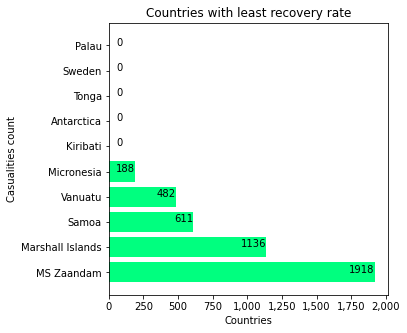

In [275]:
plot_bar_graph(least_recoveries_countries.index, least_recoveries_countries.values.tolist(), 'Countries with least recovery rate', 'Countries', 'Casualities count', color='springgreen', rotation=0, width=0.8, figsize=(5,5), million_scale=False, orient='h')

#### Checking the contribution of top countries in the entire worlds cases


In [288]:
recoveries=  country_wise_total_df.groupby('Country/Region')['recoveries'].sum()
deaths=  country_wise_total_df.groupby('Country/Region')['deaths'].sum()

confirms =  country_wise_total_df.groupby('Country/Region')['confirmed'].sum()

In [315]:
import numpy as np
np.arange(10, 100, 10).tolist()

In [347]:
compressed_rec = recoveries[recoveries<np.percentile(recoveries, 50)]
recoveries[recoveries>=np.percentile(recoveries, 50)].sum()

32994879906.0

In [348]:
(compressed_rec.sum()/recoveries.sum())*100

0.9611175249277374

In [317]:
[np.percentile(recoveries, x) for x in np.arange(10, 100, 10).tolist()]

[242781.5,
 1156600.0,
 2968287.0,
 6304452.0,
 13512174.5,
 31871648.0,
 61205450.5,
 99846263.0,
 345946299.5]

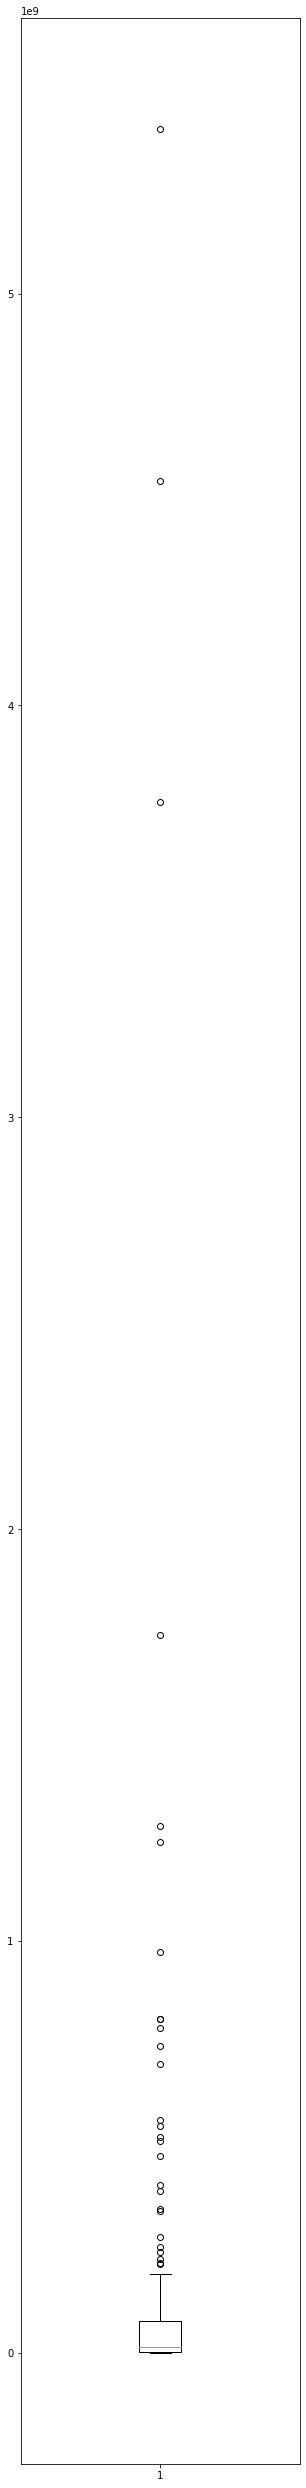

In [305]:
import matplotlib.pyplot as plt
## combine these different collections into a list
data_to_plot = [recoveries, deaths, confirms]

# Create a figure instance
fig = plt.figure(figsize=(5,45))

# Create an axes instance
# ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = plt.boxplot(recoveries)
plt.show()

In [327]:
plt.figure(figsize=(20,20))
plt.pie(x = [int(i) for i in recoveries.values.tolist()], labels =recoveries.index)
plt.show()

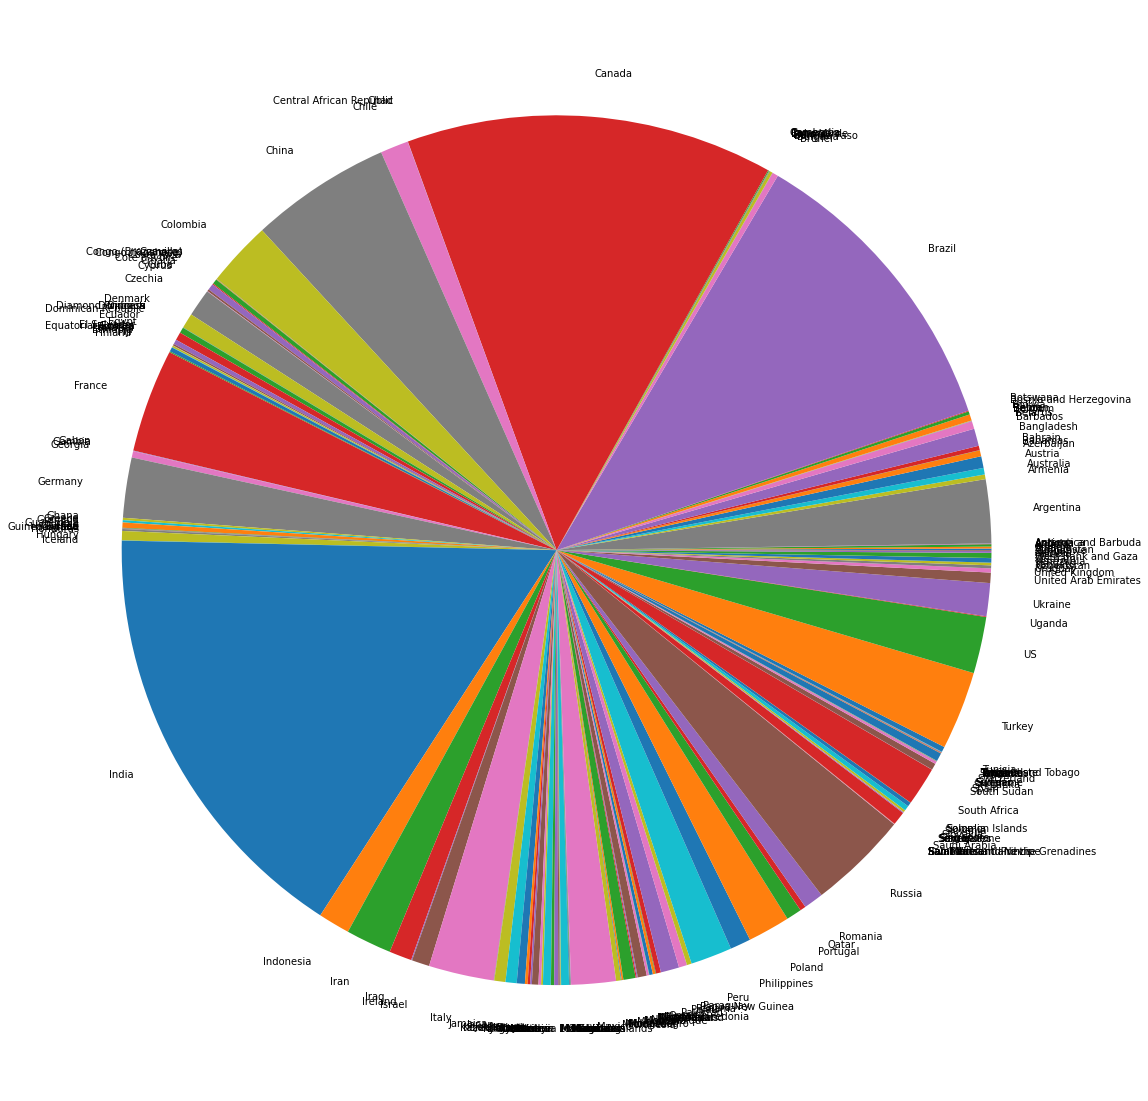

In [278]:
recoveries.values.tolist()

[20556405.0,
 23895960.0,
 28946709.0,
 3438603.0,
 6378643.0,
 0.0,
 199901.0,
 787299219.0,
 57994061.0,
 81506688.0,
 144703494.0,
 74365574.0,
 2831468.0,
 53803146.0,
 214575486.0,
 708036.0,
 95590921.0,
 4110661.0,
 3210462.0,
 1893274.0,
 318312.0,
 77354150.0,
 39172905.0,
 10212459.0,
 3765908968.0,
 91666.0,
 72185319.0,
 3105106.0,
 38635411.0,
 285662.0,
 6304452.0,
 3679757.0,
 12286243.0,
 4544057216.0,
 1646977.0,
 1184113.0,
 348671560.0,
 1743655218.0,
 809757893.0,
 810357.0,
 2724332.0,
 7608891.0,
 61396671.0,
 13040049.0,
 77409288.0,
 24408125.0,
 5237082.0,
 343221039.0,
 186171987.0,
 381616.0,
 3328242.0,
 44818.0,
 69735671.0,
 99780122.0,
 57983836.0,
 19783090.0,
 2520020.0,
 830222.0,
 20275588.0,
 4540359.0,
 52912372.0,
 178477.0,
 12737472.0,
 1279843332.0,
 5820962.0,
 1671268.0,
 78579305.0,
 744063056.0,
 28967360.0,
 28045955.0,
 41443.0,
 64726724.0,
 6582577.0,
 1096635.0,
 3239179.0,
 4081143.0,
 7957.0,
 24643613.0,
 115439419.0,
 2367275.0,
 54

#### plotting world map with cases count till date

In [358]:
confirmed_monthly = create_monthly_analysis(confirmed_df, retain_extra_columns=True)

In [362]:
confirmed_monthly.head()

,Province/State,Lat,Long,Jan 2020,Feb 2020,Mar 2020,Apr 2020,May 2020,Jun 2020,Jul 2020,...,Jul 2021,Aug 2021,Sep 2021,Oct 2021,Nov 2021,Dec 2021,Jan 2022,Feb 2022,Mar 2022,tilldate
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,33.93911,67.709953,1303865.0,1539581.0,1141.0,25152.0,222720.0,751685.0,1079412.0,...,4241348.0,4696019.0,4628009.0,4827238.0,4701215.0,4889195.0,4938320.0,4759331.0,2099077.0,7.225079e+07
Albania,NaN,41.15330,20.168300,866248.0,1540509.0,2232.0,15632.0,28873.0,50880.0,119660.0,...,4113962.0,4262873.0,4784904.0,5511591.0,5801493.0,6351823.0,7217971.0,7491180.0,3266273.0,8.736924e+07
Algeria,NaN,28.03390,1.659600,2074384.0,2884175.0,4823.0,69497.0,211394.0,337819.0,674286.0,...,4734511.0,5788899.0,6016238.0,6358229.0,6249508.0,6636393.0,7141014.0,7317457.0,3183030.0,1.032423e+08
Andorra,NaN,42.50630,1.521800,174907.0,230115.0,2787.0,19106.0,23498.0,25511.0,27174.0,...,442259.0,462595.0,453489.0,475994.0,481140.0,629689.0,931921.0,1043282.0,462564.0,9.720814e+06
Angola,NaN,-11.20270,17.873900,404417.0,508018.0,48.0,601.0,1639.0,4660.0,20049.0,...,1260968.0,1394599.0,1552460.0,1929362.0,1946699.0,2112947.0,2871481.0,2758810.0,1185745.0,2.792868e+07


<AxesSubplot:xlabel='Lat', ylabel='Long'>

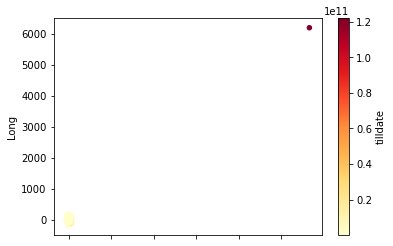

In [361]:
confirmed_monthly.plot(x="Lat", y="Long", kind="scatter", c="tilldate",
        colormap="YlOrRd")

In [364]:
import pandas as pd
import plotly.graph_objects as go

wm_df = confirmed_df.rename(columns= {"Country/Region" : "Country", "Province/State": "Province"})

In [367]:
wm_df['text'] = wm_df['Country'] + " " + wm_df["3/12/22"].astype(str)

In [380]:
wm_df[wm_df['Country']=='India']

,Province,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/4/22,3/5/22,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22,text
148,NaN,India,20.593684,78.96288,0,0,0,0,0,0,...,42957477,42962953,42967315,42971308,42975883,42980067,42984261,42987875,42990991,India 73


In [373]:
fig = go.Figure(data = go.Scattergeo(
    lon = wm_df["Long"],
    lat = wm_df["Lat"],
    text = wm_df["text"],
    mode = "markers",
    marker = dict(
        size = 12,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = True,
        symbol = 'circle',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0,
        color = wm_df['3/12/22'],
        cmax = wm_df['3/12/22'].max(),
        colorbar_title = "COVID 19 Reported Cases"
    )
))

In [374]:
fig.update_layout(
    title = "COVID19 Confirmed Cases Around the World",
    geo = dict(
        scope = "world",
        showland = True,
    )
)

fig.write_html('first_figure.html', auto_open=True)

# getting daily increment count

In [381]:
confirmed_df_testing = confirmed_df.copy()

In [382]:
confirmed_df_testing.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,174214,174214,174331,174582,175000,175353,175525,175893,175974,176039
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,271825,272030,272030,272210,272250,272337,272412,272479,272552,272621
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,265130,265186,265227,265265,265297,265323,265346,265366,265391,265410
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,38342,38434,38434,38434,38620,38710,38794,38794,38794,38794
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,98746,98796,98796,98806,98806,98829,98855,98855,98855,98909


In [385]:
confirmed_df_testing.columns

In [386]:
static_cols = ['Province/State', 'Country/Region', 'Lat', 'Long']

In [392]:
confirmed_df_testing = confirmed_df.copy()
static_cols = ['Province/State', 'Country/Region', 'Lat', 'Long']
c_diff_df = pd.DataFrame()
for i in range(0, len(confirmed_df_testing.columns)-1):
    if confirmed_df_testing.columns[i] not in static_cols:
        c_diff_df[confirmed_df_testing.columns[i]] = confirmed_df_testing[confirmed_df_testing.columns[i+1]].astype(int) - confirmed_df_testing[confirmed_df_testing.columns[i]].astype(int)

In [393]:
c_diff_df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/2/22,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22
0,0,0,0,0,0,0,0,0,0,0,...,141,0,117,251,418,353,172,368,81,65
1,0,0,0,0,0,0,0,0,0,0,...,0,205,0,180,40,87,75,67,73,69
2,0,0,0,0,0,0,0,0,0,0,...,51,56,41,38,32,26,23,20,25,19
3,0,0,0,0,0,0,0,0,0,0,...,93,92,0,0,186,90,84,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,50,0,10,0,23,26,0,0,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0,0,0,0,0,0,0,0,0,0,...,1071,861,0,0,1729,598,465,203,327,0
280,0,0,0,0,0,0,0,0,0,0,...,2,4,0,2,0,1,0,2,0,0
281,0,0,0,0,0,0,0,0,0,0,...,1,2,1,2,4,0,0,2,0,1
282,0,0,0,0,0,0,0,0,0,0,...,191,219,131,77,89,249,482,209,136,162
